In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
import xarray as xr
from dask.diagnostics import ProgressBar

In [2]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/bin/python3


In [3]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [4]:
static = xr.open_dataset('../data/usa/era5_slt_z_slor_lsm_stationary_field.nc')

In [5]:
era5 = xr.open_dataset('../data/usa/era5_lsp_cp_1981-2017_daysum.nc')

In [6]:
glofas = xr.open_dataset('../data/usa/glofas_reanalysis_usa_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
# da.transpose(dims='latitude')  # flip?

In [7]:
glofas = glofas.sel(latitude=slice(40, 28), 
                    longitude=slice(-95, -85))

In [8]:
dis = glofas['dis']

In [9]:
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
z_glofas = z_glofas.drop('time')  # time is misleading as the topography does not change

# Preprocessing routines - Summary

In [10]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

In [11]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
    b = da_timeseries - da_timeseries.mean('time')
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
    out = b.dot(a)/a.std('time')/b.std()/N
    out.name = 'correlation coefficient'
    return out

In [12]:
def select_river(dis):
    river = dis.min('time') > 5
    river.name = 'river mask [0/1]'
    return river

In [13]:
def select_upstream_river(dis_box, dis_point, z_box, z_point, rivermask, pct):
    lags = [-1, 1]

    timelag_corrs = np.full((len(lags), len(dis_box.latitude), len(dis_box.longitude)), np.nan)
    for t, lag in enumerate(lags):
        if lag > 0:  # dis_box with data from previous timesteps
            cntr = dis_point[lag:]
            dis_box_shift = dis_box[:-lag]
        elif lag < 0:  # dis_box with data from future timesteps
            cntr = dis_point[:lag]
            dis_box_shift = dis_box[-lag:]

        dis_box_relevant = dis_box_shift.where(rivermask==1)
        timelag_corrs[t,:,:] = correlate(dis_box_relevant, cntr, timelag=True)

    lag_influencing = timelag_corrs[1,:,:]>timelag_corrs[0,:,:]
    #plt.imshow(lag_influencing)

    influencer = (dis_box.mean('time') > pct*dis_point.mean('time'))  \
                  &(z_box > z_point)   \
                  &(rivermask==1) & lag_influencing
    influencer.name = 'gridpoints influencing discharge [0/1]'
    #influencer.plot()
    return influencer

In [14]:
shifts = range(1,4)
X_dis = add_shifted_predictors(glofas, shifts, variables='all')
X_dis = X_dis.drop('dis')  # we actually want to predict (t) with (t-1, t-2, t-3)
y_dis = glofas['dis']

In [15]:
i, j = 70, 38
di = 20
dj = 20
pct = 0.1  # influencing gridpoint must have mean discharge more than this percentage

i0, i1 = i-di, i+di
j0, j1 = j-dj, j+dj

dis_point = dis[:,i,j]
dis_box = dis[:, i0:i1, j0:j1]
z_point = z_glofas[i,j]
z_box = z_glofas[i0:i1,j0:j1]

rivermask = select_river(dis_box)

upstream = select_upstream_river(dis_box, dis_point, z_box, z_point, rivermask, pct)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


# Parameter-tuning for reasonable performance

In [16]:
def preprocess_reshape(X_dis, y_dis, upstream, i, j):
    X_dis = X_dis.where(upstream)
    X_dis = X_dis.to_array(dim='time_feature')  
    X_dis = X_dis.stack(features=['latitude', 'longitude', 'time_feature'])
    Xar = X_dis.dropna('features', how='all')
    
    yar = y_dis[:,i,j]
    yar = yar.drop(['latitude', 'longitude'])
    yar.coords['features'] = 'dis'
    
    Xy = xr.concat([Xar, yar], dim='features')
    Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values
    time = Xyt.time

    Xda = Xyt[:,:-1]
    yda = Xyt[:,-1]
    return Xda, yda, time

In [17]:
Xda, yda, time = preprocess_reshape(X_dis, y_dis, upstream, i,j)

In [18]:
Xda

<xarray.DataArray (time: 8032, features: 78)>
array([[ 4151.1094,  4166.663 ,  4182.    , ...,  4820.8086,  4847.2827,
         4875.5356],
       [ 4134.447 ,  4151.1094,  4166.663 , ...,  4795.667 ,  4820.8086,
         4847.2827],
       [ 4117.834 ,  4134.447 ,  4151.1094, ...,  4772.7407,  4795.667 ,
         4820.8086],
       ...,
       [ 9564.742 ,  9493.069 ,  9295.369 , ..., 10650.028 , 10404.178 ,
        10190.516 ],
       [ 9556.636 ,  9564.742 ,  9493.069 , ..., 10830.387 , 10650.028 ,
        10404.178 ],
       [ 9505.211 ,  9556.636 ,  9564.742 , ..., 10899.636 , 10830.387 ,
        10650.028 ]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1981-01-04 1981-01-05 ... 2002-12-31
  * features  (features) object (34.95, -90.24999999999999, 'dis-1') ... (33.05, -91.14999999999998, 'dis-3')

In [19]:



Xda = Xda.values
yda = yda.values[:, np.newaxis]

In [20]:
print('yda.shape:', Xda.shape, 'yda.shape:',  yda.shape)

yda.shape: (8032, 78) yda.shape: (8032, 1)


In [21]:
Xda

array([[ 4151.1094,  4166.663 ,  4182.    , ...,  4820.8086,  4847.2827,
         4875.5356],
       [ 4134.447 ,  4151.1094,  4166.663 , ...,  4795.667 ,  4820.8086,
         4847.2827],
       [ 4117.834 ,  4134.447 ,  4151.1094, ...,  4772.7407,  4795.667 ,
         4820.8086],
       ...,
       [ 9564.742 ,  9493.069 ,  9295.369 , ..., 10650.028 , 10404.178 ,
        10190.516 ],
       [ 9556.636 ,  9564.742 ,  9493.069 , ..., 10830.387 , 10650.028 ,
        10404.178 ],
       [ 9505.211 ,  9556.636 ,  9564.742 , ..., 10899.636 , 10830.387 ,
        10650.028 ]], dtype=float32)

In [22]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
#from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression

import keras
from keras.layers.core import Dropout

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [23]:
class KerasDenseNN(object):
    def __init__(self, **kwargs):
        model = keras.models.Sequential()
        self.cfg = kwargs
        ha = self.cfg.get('hidden_activation')

        for N_nodes in self.cfg.get('N_hidden_nodes'):
            # activation -> solve the dying ReLU problem
            # https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks
            hidden = keras.layers.Dense(N_nodes)
            #            bias_initializer=self.cfg.get('bias_initializer'))
                
            model.add(hidden)
            model.add(ha)
            
            if self.cfg.get('dropout'):
                model.add(Dropout(self.cfg.get('dropout')))

        outputlayer = keras.layers.Dense(1, activation='linear')
        model.add(outputlayer)

        optimizer_name, options_dict = self.cfg.get('optimizer')
        optimizer = getattr(keras.optimizers, optimizer_name)(**options_dict)

        model.compile(loss=self.cfg.get('loss'), optimizer=optimizer)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                    min_delta=0.001, patience=100, verbose=0, mode='auto',
                    baseline=None, restore_best_weights=True),]

    def predict(self, X):
        return self.model.predict(X).squeeze()

    def fit(self, X, y, **kwargs):
        return self.model.fit(X, y,
                              epochs=self.cfg.get('epochs', None),
                              batch_size=self.cfg.get('batch_size', None),
                              callbacks=self.callbacks,
                              verbose=1,
                              **kwargs)
    
    

In [24]:

mlp_kws = dict(optimizer=('RMSprop', dict(lr=0.01)),
               loss='mean_squared_error',
               N_hidden_nodes=(4,4),
               hidden_activation=keras.layers.ReLU(), #-LeakyReLU(alpha=0.3), #'relu',
               output_activation='linear',
               bias_initializer='zeros',
               batch_size=512,
               dropout=.25,
               epochs=1000,
              )


linear_kws = dict(C=.1, n_jobs=-1, max_iter=10000, verbose=True)


if False:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=4)),
                     ('model', LinearRegression(**linear_kws)),],
                    verbose=True)
if True:
    pipe = Pipeline([('scaler', StandardScaler()),
                     #('pca', PCA(n_components=4)),
                     ('model', KerasDenseNN(**mlp_kws)),],
                    verbose=True)
    

In [25]:
pipe

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model', <__main__.KerasDenseNN object at 0x7fbcca0770b8>)],
         verbose=True)

In [26]:
history = pipe.fit(Xda, yda)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Epoch 1/1000
8032/8032 [==============================] - 0s 2us/step - loss: 179570205.6414
Epoch 2/1000
8032/8032 [==============================] - 0s 2us/step - loss: 179276497.4024
Epoch 3/1000
8032/8032 [==============================] - 0s 2us/step - loss: 178761337.1155
Epoch 4/1000
8032/8032 [==============================] - 0s 2us/step - loss: 177902464.9562
Epoch 5/1000
8032/8032 [==============================] - 0s 2us/step - loss: 176704989.7689
Epoch 6/1000
8032/8032 [==============================] - 0s 2us/step - loss: 175083039.2988
Epoch 7/1000
8032/8032 [==============================] - 0s 2us/step - loss: 173210293.7371
Epoch 8/1000
8032/8032 [==============================] - 0s 2us/step - loss: 171105992.3506
Epoch 9/1000
8032/8032 [==============================] - 0s 2us/step - loss: 168991684.9721
Epoch 10/1000
8032/8032 [==============================] - 0s 2us/step - loss: 166779590.629

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


8032/8032 [==============================] - 0s 2us/step - loss: 162578219.8566
Epoch 15/1000
8032/8032 [==============================] - 0s 2us/step - loss: 162419472.7649
Epoch 16/1000
8032/8032 [==============================] - 0s 2us/step - loss: 162107856.4462
Epoch 17/1000
8032/8032 [==============================] - 0s 6us/step - loss: 162242086.3108
Epoch 18/1000
8032/8032 [==============================] - 0s 6us/step - loss: 162233536.7649
Epoch 19/1000
8032/8032 [==============================] - 0s 6us/step - loss: 162145534.2789
Epoch 20/1000
8032/8032 [==============================] - 0s 6us/step - loss: 161651636.2709
Epoch 21/1000
8032/8032 [==============================] - 0s 6us/step - loss: 161963441.2749
Epoch 22/1000
8032/8032 [==============================] - 0s 6us/step - loss: 161807569.8486
Epoch 23/1000
8032/8032 [==============================] - 0s 6us/step - loss: 161523662.2151
Epoch 24/1000
8032/8032 [==============================] - 0s 6us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 41289798.9641
Epoch 102/1000
8032/8032 [==============================] - 0s 2us/step - loss: 40880186.2629
Epoch 103/1000
8032/8032 [==============================] - 0s 2us/step - loss: 42016219.0279
Epoch 104/1000
8032/8032 [==============================] - 0s 2us/step - loss: 41286999.6494
Epoch 105/1000
8032/8032 [==============================] - 0s 2us/step - loss: 42121880.6693
Epoch 106/1000
8032/8032 [==============================] - 0s 2us/step - loss: 40919680.3347
Epoch 107/1000
8032/8032 [==============================] - 0s 2us/step - loss: 40796188.9084
Epoch 108/1000
8032/8032 [==============================] - 0s 2us/step - loss: 39988729.1315
Epoch 109/1000
8032/8032 [==============================] - 0s 2us/step - loss: 40234925.8167
Epoch 110/1000
8032/8032 [==============================] - 0s 2us/step - loss: 40499693.5777
Epoch 111/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 3us/step - loss: 37990169.7689
Epoch 189/1000
8032/8032 [==============================] - 0s 3us/step - loss: 39676652.1434
Epoch 190/1000
8032/8032 [==============================] - 0s 3us/step - loss: 39164921.4343
Epoch 191/1000
8032/8032 [==============================] - 0s 3us/step - loss: 39898738.0080
Epoch 192/1000
8032/8032 [==============================] - 0s 3us/step - loss: 39857951.0438
Epoch 193/1000
8032/8032 [==============================] - 0s 3us/step - loss: 37257578.9482
Epoch 194/1000
8032/8032 [==============================] - 0s 3us/step - loss: 40028855.8725
Epoch 195/1000
8032/8032 [==============================] - 0s 3us/step - loss: 38905088.0956
Epoch 196/1000
8032/8032 [==============================] - 0s 3us/step - loss: 39954390.7570
Epoch 197/1000
8032/8032 [==============================] - 0s 3us/step - loss: 39085538.6773
Epoch 198/1000
8032/8032 [==============================] - 0s 3us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 38530597.0199
Epoch 276/1000
8032/8032 [==============================] - 0s 2us/step - loss: 38340630.7888
Epoch 277/1000
8032/8032 [==============================] - 0s 2us/step - loss: 38674553.0199
Epoch 278/1000
8032/8032 [==============================] - 0s 2us/step - loss: 39692889.2430
Epoch 279/1000
8032/8032 [==============================] - 0s 2us/step - loss: 37953412.5100
Epoch 280/1000
8032/8032 [==============================] - 0s 2us/step - loss: 37978183.7131
Epoch 281/1000
8032/8032 [==============================] - 0s 2us/step - loss: 38413315.2510
Epoch 282/1000
8032/8032 [==============================] - 0s 2us/step - loss: 38919516.4462
Epoch 283/1000
8032/8032 [==============================] - 0s 2us/step - loss: 37251192.8606
Epoch 284/1000
8032/8032 [==============================] - 0s 2us/step - loss: 39539008.5418
Epoch 285/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 35929072.6853
Epoch 363/1000
8032/8032 [==============================] - 0s 2us/step - loss: 36836050.7410
Epoch 364/1000
8032/8032 [==============================] - 0s 2us/step - loss: 37257330.1195
Epoch 365/1000
8032/8032 [==============================] - 0s 2us/step - loss: 34923811.9522
Epoch 366/1000
8032/8032 [==============================] - 0s 2us/step - loss: 35434760.1753
Epoch 367/1000
8032/8032 [==============================] - 0s 2us/step - loss: 37503640.1594
Epoch 368/1000
8032/8032 [==============================] - 0s 2us/step - loss: 36278952.0159
Epoch 369/1000
8032/8032 [==============================] - 0s 2us/step - loss: 36199578.4382
Epoch 370/1000
8032/8032 [==============================] - 0s 2us/step - loss: 36462340.7171
Epoch 371/1000
8032/8032 [==============================] - 0s 2us/step - loss: 36859586.7251
Epoch 372/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 34787186.0558
Epoch 450/1000
8032/8032 [==============================] - 0s 2us/step - loss: 33580376.3984
Epoch 451/1000
8032/8032 [==============================] - 0s 2us/step - loss: 34060130.2151
Epoch 452/1000
8032/8032 [==============================] - 0s 2us/step - loss: 34930096.0956
Epoch 453/1000
8032/8032 [==============================] - 0s 2us/step - loss: 33875353.7689
Epoch 454/1000
8032/8032 [==============================] - 0s 2us/step - loss: 35319221.7689
Epoch 455/1000
8032/8032 [==============================] - 0s 2us/step - loss: 34617861.6335
Epoch 456/1000
8032/8032 [==============================] - 0s 2us/step - loss: 35183467.4900
Epoch 457/1000
8032/8032 [==============================] - 0s 2us/step - loss: 32912724.2948
Epoch 458/1000
8032/8032 [==============================] - 0s 2us/step - loss: 34150577.1474
Epoch 459/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 32611468.9721
Epoch 537/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30602944.2151
Epoch 538/1000
8032/8032 [==============================] - 0s 2us/step - loss: 32056926.9801
Epoch 539/1000
8032/8032 [==============================] - 0s 2us/step - loss: 33332595.3466
Epoch 540/1000
8032/8032 [==============================] - 0s 2us/step - loss: 32953560.3108
Epoch 541/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31231528.7888
Epoch 542/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31868126.0239
Epoch 543/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31678784.5737
Epoch 544/1000
8032/8032 [==============================] - 0s 2us/step - loss: 32868652.0956
Epoch 545/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31819930.6375
Epoch 546/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 30278615.0518
Epoch 624/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30307874.4542
Epoch 625/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30202410.3347
Epoch 626/1000
8032/8032 [==============================] - 0s 2us/step - loss: 32368236.9721
Epoch 627/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31127613.9920
Epoch 628/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30543640.3745
Epoch 629/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30665497.4183
Epoch 630/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31508294.4622
Epoch 631/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31394706.3745
Epoch 632/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30766112.3586
Epoch 633/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 31332034.1434
Epoch 711/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31593441.1952
Epoch 712/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30529499.9442
Epoch 713/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30795532.1594
Epoch 714/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30059816.1992
Epoch 715/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31088113.3466
Epoch 716/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31128951.2988
Epoch 717/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30704480.5578
Epoch 718/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30456757.8327
Epoch 719/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30602435.8088
Epoch 720/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 32164414.8526
Epoch 798/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30719023.5936
Epoch 799/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30899022.4861
Epoch 800/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30328644.9721
Epoch 801/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30730739.2510
Epoch 802/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30760063.1952
Epoch 803/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30632024.7012
Epoch 804/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30461318.7251
Epoch 805/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31118881.1076
Epoch 806/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31276420.4462
Epoch 807/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 31316816.7490
Epoch 885/1000
8032/8032 [==============================] - 0s 2us/step - loss: 29891668.8606
Epoch 886/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30399536.1753
Epoch 887/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30463873.7610
Epoch 888/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31540989.7371
Epoch 889/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30619739.9841
Epoch 890/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30763473.9841
Epoch 891/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30472872.1355
Epoch 892/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31440280.8446
Epoch 893/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31860764.1594
Epoch 894/1000
8032/8032 [==============================] - 0s 2us/step - l

8032/8032 [==============================] - 0s 2us/step - loss: 30491775.9681
Epoch 972/1000
8032/8032 [==============================] - 0s 2us/step - loss: 32623949.9602
Epoch 973/1000
8032/8032 [==============================] - 0s 2us/step - loss: 32382111.6096
Epoch 974/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31204409.3546
Epoch 975/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31238809.7849
Epoch 976/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31352668.1116
Epoch 977/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30973324.1036
Epoch 978/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30156137.4183
Epoch 979/1000
8032/8032 [==============================] - 0s 2us/step - loss: 30323209.2430
Epoch 980/1000
8032/8032 [==============================] - 0s 2us/step - loss: 31559272.5657
Epoch 981/1000
8032/8032 [==============================] - 0s 2us/step - l

In [27]:
keras.utils.print_summary(pipe.named_steps['model'].model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 316       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


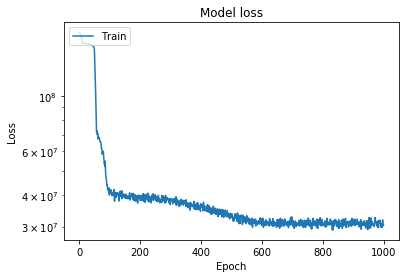

In [28]:
h = history.named_steps['model'].model.history

# Plot training & validation loss values
plt.plot(h.history['loss'])
#plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.gca().set_yscale('log')
plt.show()

# Test it on the same data

In [29]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [30]:
with ProgressBar():
    ytest = pipe.predict(Xda)

In [31]:
ytest.shape

(8032,)

In [32]:
ytest = add_time(ytest, time, name='dis-forecast')
ytest_dis = ytest #.cumsum('time')
ytest_dis.values
#ytest_dis += y[0]  # initial state + changes = timeseries of forecasted discharge

array([3692.2976, 3692.293 , 3692.2878, ..., 3693.2407, 3693.254 ,
       3693.2512], dtype=float32)

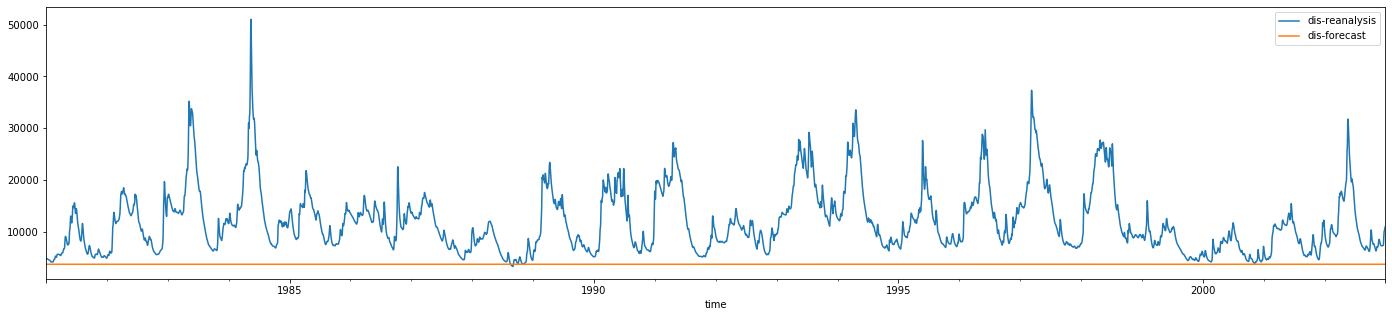

In [33]:
fig, ax = plt.subplots(figsize=(24,5))
obs = dis[:,i,j].to_pandas()
fcst = ytest_dis.to_pandas()
obs.plot(ax=ax, label='dis-reanalysis')
fcst.plot(ax=ax, label='dis-forecast')
plt.legend()

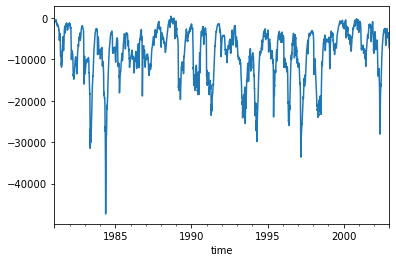

In [34]:
(fcst-obs).plot()